## Yum or Yuck Butterfly Mimics 2022 – Baseline Model

**Author:** [Keith Pinson](https://github.com/keithpinson)<br>
**Date created:** 2022/06/11<br>
**Version:** 1.0.0001<br>
**Description:** A simple transfer learning model to establish a baseline score for a Kaggle Community Competition where we try to classify the name of the butterfly in each given image.<br>
**Platform:** Kaggle Packages including Tensorflow 2.6.3 with GPU support<br>
<br>

![Butterfly Classification Diagram](DocResources/ButterflyClassificationTransferLearning-854.png)

We will use the pre-trained weights of the EfficientNet convolutional neural network with the Imagenet dataset.  The final classification layers will be replaced with our own very simple layer to make the butterfly classifier. We will not do any fine-tuning of the pre-trained model although we will allow the network to retrain by not freezing the weights.

In [1]:
import datetime

import pandas

print("executed",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),"local time")

executed 2022-07-11 08:23:28 local time


---
Using TensorFlow we will a build a butterfly image classifier that will be able to identify 6 remarkable North American butterflies. The Monarch and Pipevine caterpillars sequester toxins: cardiac glycoside and aristolochic acid, from their host plants as they feed. Birds find these butterflies distasteful. They are yucky. The other butterflies mimic the Monarch or Pipevine butterflies and are yummy. Well, except for the Viceroy, since it is both yucky and a mimic, as it sequesters salicylic acid when a caterpillar.

Our goal is to accurately identify the butterflies by name.

![Images of Black, Monarch, Pipevine, Spicebush, Tiger and Viceroy butterflies from the dataset](DocResources/the-butterflies.png)

<br>
This notebook will:

 - Load EfficientNet with the pre-trained Imagenet weights
 - Load the Butterfly Mimics dataset
 - Create a new set of feature weights using our own classifier
 - Predict the butterflies from the test
 - Show a sample of the results
 - Quantify the accuracy of the results



---
## Set Hyperparameters
---

In [2]:
# Hyper-parameters
LEARNING_RATE = 0.0003
NUMBER_OF_EPOCHS = 20

# Other constants
IMAGE_WIDTH = IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)  # Rows, Columns order
IMAGE_DEPTH = 3
BATCH_SIZE = 64
BUFFER_SIZE = 1024
MODEL_NAME = 'yoymimics'

SEED = 43

##
---
## Set Environment
---


In [183]:
import os
import random
from io import StringIO
import csv

import tensorflow as tf

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Using TensorFlow's enhanced version of Numpy
import tensorflow.experimental.numpy as np
np.experimental_enable_numpy_behavior()

AUTOTUNE = tf.data.experimental.AUTOTUNE

import pandas as pd
from matplotlib import pyplot as plt, patches

import IPython.display as display

from keras.callbacks import EarlyStopping
from keras.layers import \
    Activation, \
    BatchNormalization, \
    Conv2D, \
    Dense, \
    Dropout, \
    Flatten, \
    GlobalAveragePooling2D, \
    MaxPooling2D, \
    RandomCrop, \
    RandomRotation, \
    RandomTranslation, \
    RandomZoom

from keras.metrics import \
    RootMeanSquaredError, \
    MeanSquaredError, \
    Accuracy

from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model


os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed = SEED
np.random.seed = SEED
tf.random.set_seed(SEED)

print(f"Tensorflow {tf.__version__}", "with GPU support" if len(tf.config.list_physical_devices('GPU')) > 0 else "for CPU only")

Tensorflow 2.6.3 with GPU support


### <u>Convenient functions</u>

In [65]:
def decode_image(image):
    # image.shape == tf.TensorShape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    return tf.keras.utils.array_to_img(image.numpy())

def decode_label(label):
    # label.shape == tf.TensorShape([class_count])
    return butterfly_classes[tf.argmax(label)].numpy().decode('UTF-8')

def decode_image_id(image_id):
    # image_id.shape == tf.TensorShape([1])
    return image_id.numpy()[0].decode('UTF-8')


### <u>Dataset paths and names</u>


In [4]:
dataset_name = "YOYMimics-2022-dataset"

# Setting the variables assuming a Windows platform
base_dir = "."
data_dir = os.path.join(base_dir, dataset_name, 'data', 'butterfly_mimics')
working_dir = os.path.join(os.environ.get("HOMEPATH"), dataset_name)
temp_dir = os.path.join(os.environ.get("TMP"), dataset_name)

train_dir = os.path.join(data_dir, 'images')
test_dir = os.path.join(data_dir, 'image_holdouts')
train_csv = os.path.join(data_dir, 'images.csv')
test_csv = os.path.join(data_dir, 'image_holdouts.csv')

class_names = ['black', 'monarch', 'pipevine', 'spicebush', 'tiger', 'viceroy']
class_count = len(class_names)

##
---
## Load Pre-trained Weights
---

Note that final, top layer is not included. We will replace these dense layers of the image classifier with our own.

In [5]:
# EfficientNetV2 was added in TensorFlow 2.8
from keras.applications.efficientnet import EfficientNetB1

headless_efficientnet = EfficientNetB1(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH)
)

print("Shape of pre-trained network:", headless_efficientnet.output_shape[1:])


Shape of pre-trained network: (7, 7, 1280)


##
---
## Build the Butterfly Classifier
---

This is the new classifier that replaces the top layer of the pre-trained model. We will *fit* the model with our dateset in a later step, below.

In [6]:
def butterfly_classifier(x):

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # This is the place to improve the classifier.
    # Just as an example you could add:
    #
    # x = Dropout(0.2)(x)
    # x = Dense(512, activation='relu')(x)

    return x


In [7]:
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))

# We wind our way from inputs to outputs
x = inputs

x = RandomRotation(factor=0.2, fill_mode='nearest', seed=SEED)(x)
x = RandomZoom((-0.2, 0.2), fill_mode='nearest', seed=SEED)(x)
x = headless_efficientnet(x, training=True)  # This could be run in inference mode with training=False
x = butterfly_classifier(x)

outputs = Dense(class_count, activation='softmax')(x)


butterfly_model = tf.keras.Model(inputs, outputs, name=MODEL_NAME)


In [8]:
butterfly_model.summary()

Model: "yoymimics"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 6,582,925
Trainable params: 6,520,870
Non-trainable params: 62,055
__________________________________________

In [15]:
layer = butterfly_model.layers[-1]
print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))
print("trainable_variables:", len(butterfly_model.trainable_variables))
print("non_trainable_variables:", len(butterfly_model.non_trainable_variables))


weights: 2
trainable_weights: 2
non_trainable_weights: 0
trainable_variables: 301
non_trainable_variables: 141


##
---
## Build Dataset Pipeline
---

The Butterfly Mimics 2022 Dataset consists of JPG images of a single butterfly. In the training data we are given a label that identifies the class of each butterfly as either *black*, *monarch*, *pipevine*, *spicebush*, *tiger*, or *viceroy*.<br>

![Tiger Swallowtail Butterfly](DocResources/tiger_female_dark_form_vyaa1ee082.jpg)
<br>

```python
X = vyaa1ee082.jpg # Features
y = "tiger"        # Target
```

The dataset provides two folders of images. One with class labels for training. And, one without class labels to test your model for the Public Leaderboard.

- Training data is referred to as the `'images'`
- Test data is referred to as the `'image_holdouts'`

No data from the `'image_holdouts'` is used to generate our baseline scores.

## &nbsp;
### Our ETL Pipeline:
###
| <u>Extract</u> | <u>Transform</u> | <u>Load</u> |
| :----- | :------- | :-- |
| *Read* dataset stored locally on disk | Step 1: *Split* into training and evaluating sets | *Feed* the data to the model |
|                                     | Step 2: *Pre-process* |
|                                     | Step 3: *Map* image names to image features |


### <u>Read</u>

In [16]:
presplit_csv_data = pd.read_csv(train_csv)
test_csv_data = pd.read_csv(test_csv)

butterfly_count = len(presplit_csv_data)


### <u>Split</u>

In [17]:
# Very simple split into training and validate datasets
eval_fraction = 0.15
eval_count = int(butterfly_count//BATCH_SIZE * eval_fraction + 0.5) * BATCH_SIZE
train_count = butterfly_count - eval_count

train_csv_data = presplit_csv_data[:train_count]
eval_csv_data = presplit_csv_data[train_count:]

### <u>Map and Preprocess</u>

We define some mapping functions that we will use in the TensorFlow pipeline. Pay particular attention to `tf.numpy_function()`, without it this workflow of reading the CSV and then loading our images later would not easily work using TensorFlow data.Dataset.

In [18]:
butterfly_classes = np.array(class_names, dtype='str')

def get_feature_and_label_function(image_id, class_name):
    _image_id = image_id[0].decode('UTF-8')
    _class_name = class_name[0].decode('UTF-8')

    _img = tf.io.read_file(os.path.join(
        train_dir, _image_id + '.jpg'))

    _img = tf.image.decode_jpeg(_img,
        channels=IMAGE_DEPTH,
        dct_method='INTEGER_ACCURATE',
        name=_image_id)

    _img = tf.image.resize(_img,IMAGE_SIZE)

    _img = tf.cast(_img, tf.float32)/255.0

    name_label = tf.convert_to_tensor(_class_name)

    one_hot = name_label == butterfly_classes

    # encoded_label = tf.argmax(one_hot)
    encoded_label = one_hot.astype(np.float32)

    return _img, encoded_label, image_id

def get_feature_and_label(x,y):

    features_labels = tf.numpy_function(
        get_feature_and_label_function,
        [x,y],
        [tf.float32,tf.float32,tf.string]
    )

    # numpy_function() loses the shapes, we will need to restore them

    features_labels[0].set_shape(
        tf.TensorShape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    )

    features_labels[1].set_shape(tf.TensorShape([class_count]))

    features_labels[2].set_shape(tf.TensorShape([1]))
    tf.cast(features_labels[2], tf.string, name='image_id')

    return features_labels

def clear_label(image_feature, label, image_id):
    _label = np.array([0.,0.,0.,0.,0.,0.],dtype=np.float32)
    return image_feature, _label, image_id

def drop_image_id(image_feature, label, image_id):
    return image_feature, label

def train_preprocess(image_feature, label):
    _img = tf.image.random_flip_left_right(image_feature)

    _img = tf.image.random_brightness(_img, max_delta=32.0 / 255.0)
    _img = tf.image.random_saturation(_img, lower=0.5, upper=1.5)

    # Make sure the image is still in [0, 1]
    _img = tf.clip_by_value(_img, 0.0, 1.0)

    return _img, label


Map the strings into the actual tensors and vectors.

In [19]:
# Map the training and validating datasets, as well as an eval dataset that
# is a stand-in for the test dataset

# Training Dataset
butterfly_images = pd.DataFrame(train_csv_data[['image']].values.tolist())
butterfly_names = pd.DataFrame(train_csv_data[['name']].values.tolist())

train_ds_prebatch = tf.data.Dataset.from_tensor_slices((butterfly_images,butterfly_names))
train_ds_prebatch = train_ds_prebatch.map(get_feature_and_label , num_parallel_calls=AUTOTUNE)


# Eval Dataset
eval_images = pd.DataFrame(eval_csv_data[['image']].values.tolist())
eval_names = pd.DataFrame(eval_csv_data[['name']].values.tolist())

eval_ds_prebatch = tf.data.Dataset.from_tensor_slices((eval_images,eval_names))
eval_ds_prebatch = eval_ds_prebatch.map(get_feature_and_label , num_parallel_calls=AUTOTUNE)

# Validating Dataset
validate_ds_prebatch = eval_ds_prebatch

#
# At this point our datasets have an image, label, and image_id component,
# we need to change this
#

train_ds_prebatch = train_ds_prebatch.map(drop_image_id)        # Drop image id
validate_ds_prebatch = validate_ds_prebatch.map(drop_image_id)  # Drop image id

# Finish preprocessing Training Dataset
train_ds_prebatch = train_ds_prebatch.repeat(12).shuffle(buffer_size=BUFFER_SIZE)
train_ds_prebatch = train_ds_prebatch.map(train_preprocess, num_parallel_calls=AUTOTUNE)
train_ds_prebatch = train_ds_prebatch.cache()

# The validation that runs with the training should be the size
validate_ds_prebatch = validate_ds_prebatch.repeat(12)
validate_ds_prebatch = validate_ds_prebatch.cache()


Let's pause for moment and walk a batch through our model and make sure things are working as we expect.

In [20]:
x, y = next(iter(train_ds_prebatch.batch(BATCH_SIZE)))

print("                   Shapes")
print("                   ------")
print("     input batch: ", x.shape)
x = headless_efficientnet(x)
print("      base model: ", x.shape)
x = butterfly_classifier(x)
print("classifier model: ", x.shape)
x = Dense(class_count)(x)
print("prediction layer: ", x.shape)


                   Shapes
                   ------
     input batch:  (64, 224, 224, 3)
      base model:  (64, 7, 7, 1280)
classifier model:  (64, 1280)
prediction layer:  (64, 6)


Shapes:
<CacheDataset shapes: ((224, 224, 3), (6,)), types: (tf.float32, tf.float32)>

image shape: (224, 224, 3)
label shape: (6,) 			 tf.Tensor([0. 0. 0. 0. 0. 1.], shape=(6,), dtype=float32)

viceroy


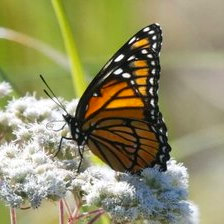

In [21]:
# Check the shapes that the mapping gave us
print("Shapes:")
print(train_ds_prebatch)
print()
image, label = next(iter(train_ds_prebatch.skip(9)))
print("image shape:", image.shape)
print("label shape:", label.shape, "\t\t\t", label)
print()
print(decode_label(label))
display.display(decode_image(image))


### <u>Load</u>

We first batch the datasets and then they will be loaded by the TensorFlow model.fit() method.

In [22]:
# Batch and prefetch the datasets now
train_ds_prebatch = train_ds_prebatch.shuffle(train_count)
train_ds_batch = train_ds_prebatch.batch(BATCH_SIZE)
train_ds = train_ds_batch.prefetch(AUTOTUNE)

eval_ds = eval_ds_prebatch.batch(BATCH_SIZE)

validate_ds_batch = validate_ds_prebatch.batch(BATCH_SIZE)
validate_ds = validate_ds_batch.prefetch(AUTOTUNE)

We can confirm the dataset is ready by taking a peek at the first batch.

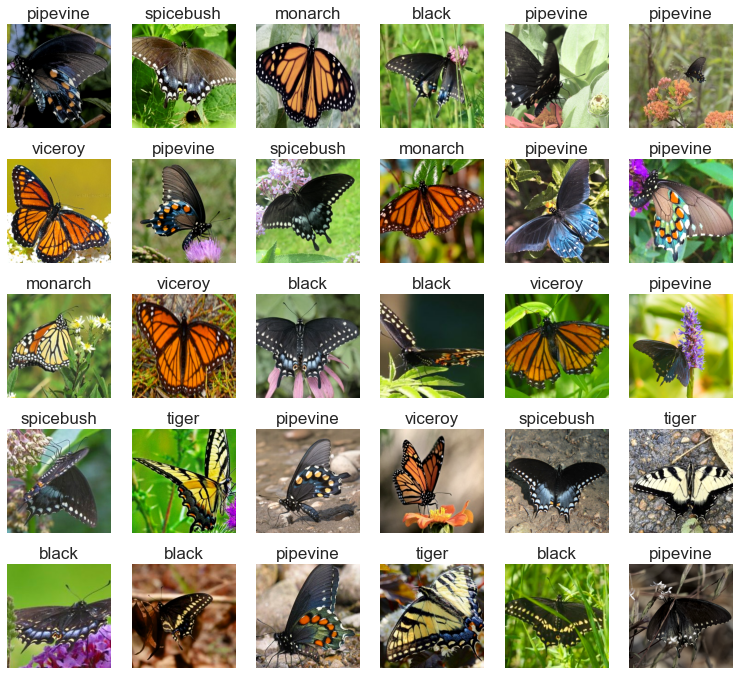

In [23]:
plt.figure(figsize=(13,12))

# Get the first batch
image_batch, label_batch = next(iter(train_ds.shuffle(train_count,reshuffle_each_iteration=True)))

rows = 5
cols = 6
for i in range(rows*cols):
    butterfly_image = decode_image(image_batch[i])
    butterfly_label = decode_label(label_batch[i])

    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(butterfly_image)
    plt.title(butterfly_label, fontsize=17)
    plt.axis("off")

plt.show()


---
## Train the Model
---

We will compile() and fit() to train our model with given dataset.

In [24]:
stop_early = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=50,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)


headless_efficientnet.trainable = True  # Don't freeze weights in all layers

butterfly_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy'])

fit_history = butterfly_model.fit(
    train_ds,
    shuffle=True,
    epochs=NUMBER_OF_EPOCHS,
    callbacks=[stop_early],
    validation_data=validate_ds,
    verbose=1
)


Epoch 1/20
136/136 [==============================] - 73s 393ms/step - loss: 0.3667 - accuracy: 0.8685 - val_loss: 0.3538 - val_accuracy: 0.8861
Epoch 2/20
136/136 [==============================] - 48s 349ms/step - loss: 0.0324 - accuracy: 0.9906 - val_loss: 0.4143 - val_accuracy: 0.8984
Epoch 3/20
136/136 [==============================] - 48s 353ms/step - loss: 0.0268 - accuracy: 0.9923 - val_loss: 0.4440 - val_accuracy: 0.8789
Epoch 4/20
136/136 [==============================] - 49s 358ms/step - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.4427 - val_accuracy: 0.8919
Epoch 5/20
136/136 [==============================] - 48s 353ms/step - loss: 0.0088 - accuracy: 0.9969 - val_loss: 0.4218 - val_accuracy: 0.9069
Epoch 6/20
136/136 [==============================] - 48s 352ms/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 0.3928 - val_accuracy: 0.8965
Epoch 7/20
136/136 [==============================] - 49s 358ms/step - loss: 0.0115 - accuracy: 0.9970 - val_loss: 0.3076 - val_ac

---
## Visualize the Training
---

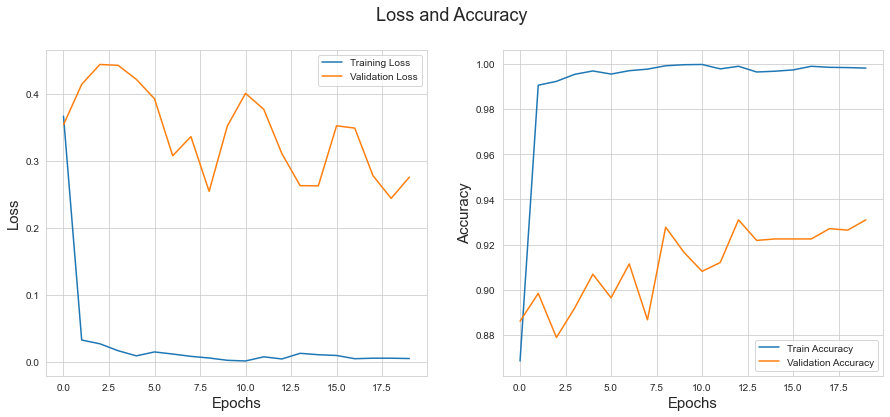

In [25]:
plt.figure(figsize=(15,6))

plt.suptitle('Loss and Accuracy', fontsize=18)

# Visualize Loss vs Epochs
plt.subplot(1,2,1)
plt.plot(fit_history.history['loss'], label='Training Loss')
plt.plot(fit_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

# Visualize Accuracy vs Epochs
plt.subplot(1,2,2)
plt.plot(fit_history.history['accuracy'], label='Train Accuracy')
plt.plot(fit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.show()

In [27]:
# Now that the model is trained we can evaluate it and see that it is quite good
eval_result = butterfly_model.evaluate(validate_ds)
dict(zip(butterfly_model.metrics_names, eval_result))

24/24 [==============================] - 3s 102ms/step - loss: 0.2700 - accuracy: 0.9290


{'loss': 0.26995849609375, 'accuracy': 0.9290364384651184}

---
## Make the Predictions
---

Like `evaluate()` which we just ran, we can run `predict()` but we will have to do some work to visualize the results.

In [29]:
y_predictions = butterfly_model.predict(eval_ds, verbose=1)

2/2 [==============================] - 3s 256ms/step


In [32]:
def decode_predictions(preds, name_list, top=1):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]

        result = [tuple([name_list[i]]) + (pred[i], ) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)

    return results

predicted_label_confidence = decode_predictions(y_predictions, class_names)


In [223]:
# Combine the actual and predicted data together into a single list
es = eval_ds_decoded = [(decode_image(m),decode_label(l),decode_image_id(id)) for (m, l, id) in eval_ds.unbatch()]
ps = predicted_label_confidence

# Zip the tuples
predictions = [(es[i][0],es[i][1],es[i][2],ps[i]) for i in range(len(es))]


xje9c102c5, viceroy


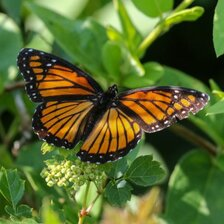

In [228]:
i = 4
image = predictions[i][0]
name = predictions[i][1]
image_id = predictions[i][2]
prediction = predictions[i][3]

print(f"{image_id}, {name}")
display.display(image)


---
## Visualize Results
---

In [229]:
j = 0
show_actual = True


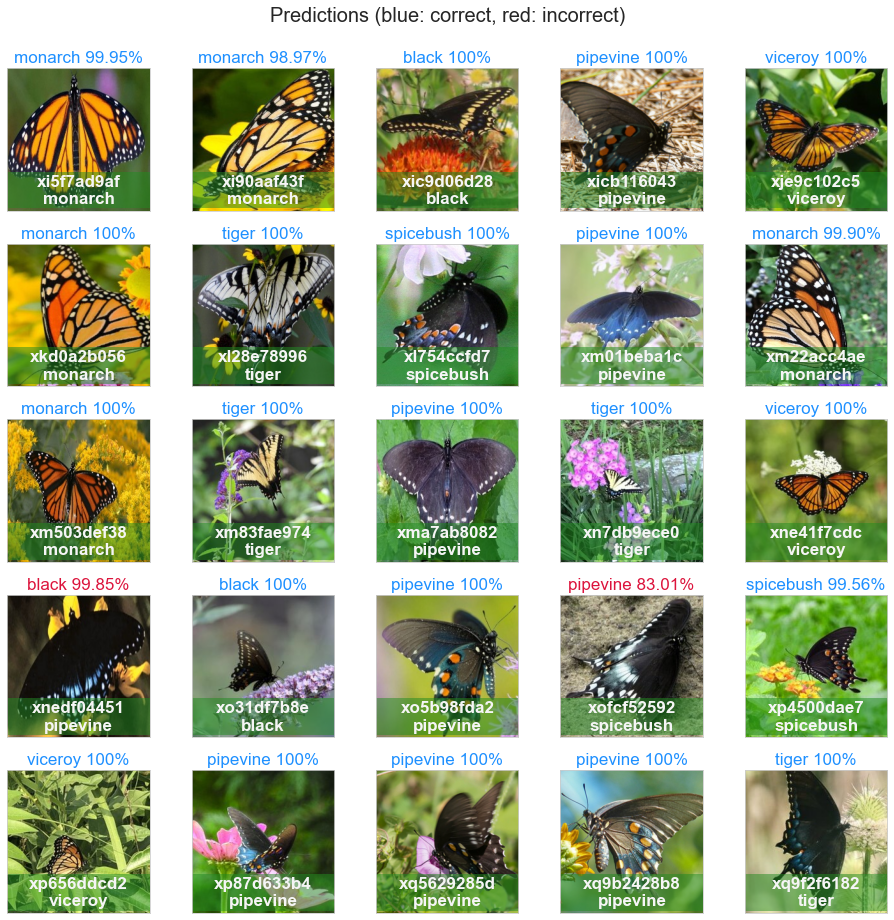

In [230]:
# Run this cell over and over to step through the predictions

rows = 5
cols = 5

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(13, 13),
                        subplot_kw={'xticks': [], 'yticks': []})

plt.suptitle("Predictions (blue: correct, red: incorrect)\n", fontsize=20)

maxloop = len(predictions)//(rows*cols)

if j <= maxloop:
    for i, ax in enumerate(axs.flat):
        k = (j*rows*cols) + i

        if k < len(predictions):

            image = predictions[k][0]
            name = predictions[k][1]
            image_id = predictions[k][2]
            prediction = predictions[k][3]

            description = f"{image_id}\n{name}"

            p_label = prediction[0][0]
            p_confidence = prediction[0][1]
            p_percent = "{:.2%}".format(p_confidence) \
                if p_confidence < 1.0 else "100%"

            p_description = f"{p_label} {p_percent}"

            color = "dodgerblue" if name == p_label else "crimson"

            ax.grid(None)
            ax.axis('on')

            ax.set_title(p_description, color=color, fontsize=17)

            ax.imshow(image, interpolation_stage='rgb', alpha=1.0)

            if show_actual:
                rectangle = patches.Rectangle((0, IMAGE_HEIGHT-62), IMAGE_WIDTH, 58, facecolor="forestgreen", linewidth=0, alpha=.5)
                ax.add_patch(rectangle)

                ax.annotate(description, (IMAGE_WIDTH//2, IMAGE_HEIGHT-33), color='whitesmoke', weight='bold', fontsize=17, ha='center', va='center')

            ax.set(xticks=[], yticks=[], xlabel='')
        else:
            ax.set_visible(False)

    # fig.text(.05, .95, f"{j}", color='k', fontsize=17)

    j = j + 1 if j < maxloop else 0
    plt.tight_layout(h_pad=1.5)
    plt.show()

---
## Save the CSV
---


In [239]:
preds_df = pd.DataFrame([(p[2],p[3][0][0],p[3][0][1]) for p in predictions],
        columns=['image','name','confidence'])

preds_df.to_csv("submission.csv", header=True, index=False)

print('CSV file saved')

print(preds_df)


CSV file saved
          image       name  confidence
0    xi5f7ad9af    monarch    0.999512
1    xi90aaf43f    monarch    0.989746
2    xic9d06d28      black    1.000000
3    xicb116043   pipevine    1.000000
4    xje9c102c5    viceroy    1.000000
..          ...        ...         ...
123  zy16ddb9f1      black    1.000000
124  zy67bc70c5   pipevine    1.000000
125  zz27202dc0  spicebush    1.000000
126  zzd5daae92  spicebush    1.000000
127  zze50f4f4f  spicebush    0.999512

[128 rows x 3 columns]


---
## Next Steps
---

The results are stellar. However, there is still room for improvement. So, some things to try:
 - Use a better base model or roll-your-own model
 - Fine-tune the model
 - Add more augmented images
 - Improve the classifier

In [23]:
tf.keras.backend.clear_session()